In [2]:
!pip install -U torch torchvision

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 114.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 105.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 82.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 27.1 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 124.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 102.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 104.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 111.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 10.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 111.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid
from torch.cuda.amp import autocast, GradScaler
import utils
import pandas as pd
import io
import random
import time
import zipfile

import utils
import importlib
utils = importlib.reload(utils)

In [2]:
torch.cuda.is_available()

True

In [4]:
class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, kernel_size=3, stride=2):
        super(Encoder, self).__init__()
        
        
        # FM mod
        self.strided_conv_1 = nn.Conv1d(in_channels=112, out_channels=512, kernel_size=kernel_size, padding=1)
        self.strided_conv_2 = nn.Conv1d(in_channels=512, out_channels=512, kernel_size=kernel_size, padding=0)
        
        self.residual_conv_1 = nn.Conv1d(in_channels=512, out_channels=512, kernel_size=kernel_size, padding=1)
        self.residual_conv_2 = nn.Conv1d(in_channels=512, out_channels=512, kernel_size=kernel_size, padding=1)
        
        self.proj = nn.Conv1d(in_channels=512, out_channels=16, kernel_size=3)
        
    def forward(self, x):
        x = self.strided_conv_1(x)
        x = self.strided_conv_2(x)
        
        x = F.relu(x)
        y = self.residual_conv_1(x)
        y = y+x
        
        x = F.relu(y)
        y = self.residual_conv_2(x)
        #print(y.shape)
        #print(x.shape)
        y = y+x
        
        y = self.proj(y)
        print("Encoder output: ", y.shape)
        return y
    

In [5]:
class VQEmbeddingEMA(nn.Module):
    """
    After every epoch, run this for random restart:
    random_restart()
    reset_usage()
    """
    def __init__(self, n_embeddings, embedding_dim, commitment_cost=0.25, decay=0.999, epsilon=1e-5, usage_threshold=1.0e-9):
        super(VQEmbeddingEMA, self).__init__()
        self.commitment_cost = commitment_cost
        self.decay = decay
        self.epsilon = epsilon
        self.usage_threshold = usage_threshold
        self.n_embeddings = n_embeddings
        self.embedding_dim = embedding_dim
        
        # init_bound = 1 / n_embeddings
        embedding = torch.Tensor(n_embeddings, embedding_dim)
        # embedding.uniform_(-init_bound, init_bound)  # try other types on initialization 
        # Xavier initalization is designed to keep the scale of the gradients roughly the same in all layers
        nn.init.xavier_uniform_(embedding)
        self.register_buffer("embedding", embedding)
        self.register_buffer("ema_count", torch.zeros(n_embeddings))
        self.register_buffer("ema_weight", self.embedding.clone())

        # initialize usage buffer for each code as fully utilized
        self.register_buffer('usage', torch.ones(self.n_embeddings), persistent=False)

    def update_usage(self, min_enc):
        self.usage[min_enc] = self.usage[min_enc] + 1  # if code is used add 1 to usage
        self.usage /= 2 # decay all codes usage

    def reset_usage(self):
        print("Reset usage of embeddings between epochs\n")
        self.usage.zero_() #  reset usage between epochs

    def random_restart(self):
        #  randomly restart all dead codes below threshold with random code in codebook
        dead_codes = torch.nonzero(self.usage < self.usage_threshold).squeeze(1)
        print("Are there any dead codes on this epoch? ", len(dead_codes))  # torch.any(dead_codes != 0))
        rand_codes = torch.randperm(self.n_embeddings)[0:len(dead_codes)]
        with torch.no_grad():
            self.embedding[dead_codes] = self.embedding[rand_codes]

    def encode(self, x):
        x_flat = x.detach().reshape(-1, self.embedding_dim)

        distances = (-torch.cdist(x_flat, self.embedding, p=2)) ** 2

        indices = torch.argmin(distances.float(), dim=-1)
        quantized = F.embedding(indices, self.embedding)
        quantized = quantized.view_as(x)
        return quantized, indices.view(x.size(0), x.size(1))
    
    def retrieve_random_codebook(self, random_indices):
        quantized = F.embedding(random_indices, self.embedding)
        quantized = quantized.transpose(1, 3)
        return quantized

    def forward(self, x):
        # M, D = self.embedding.size()
        x_flat = x.detach().reshape(-1, self.embedding_dim)
        
        distances = (-torch.cdist(x_flat, self.embedding, p=2)) ** 2

        # find closest encodings
        # min_encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        # min_encodings = torch.zeros(
        #     min_encoding_indices.shape[0], self.n_embeddings).type_as(z)
        ### min_encodings.scatter_(1, min_encoding_indices, 1)

        indices = torch.argmin(distances.float(), dim=-1)
        encodings = F.one_hot(indices, self.n_embeddings).float()
        quantized = F.embedding(indices, self.embedding)
        quantized = quantized.view_as(x)
        
        if self.training:
            self.ema_count = self.decay * self.ema_count + (1 - self.decay) * torch.sum(encodings, dim=0)
            n = torch.sum(self.ema_count)
            self.ema_count = (self.ema_count + self.epsilon) / (n + self.n_embeddings * self.epsilon) * n
            dw = torch.matmul(encodings.t(), x_flat)
            self.ema_weight = self.decay * self.ema_weight + (1 - self.decay) * dw
            self.embedding = self.ema_weight / self.ema_count.unsqueeze(-1)

        self.update_usage(indices)
        
        codebook_loss = F.mse_loss(x.detach(), quantized)
        e_latent_loss = F.mse_loss(x, quantized.detach())
        commitment_loss = self.commitment_cost * e_latent_loss

        # preserve gradients
        quantized = x + (quantized - x).detach()

        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        return quantized, commitment_loss, codebook_loss, perplexity

In [6]:
class Decoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, kernel_size=3, stride=2):
        super(Decoder, self).__init__()
        
        '''
        self.in_proj = nn.Conv2d(input_dim, hidden_dim, kernel_size=1)
        
        self.residual_conv_1 = nn.Conv2d(hidden_dim, hidden_dim, kernel_1, padding=1)
        self.residual_conv_2 = nn.Conv2d(hidden_dim, hidden_dim, kernel_2, padding=0)
        
        self.strided_t_conv_1 = nn.ConvTranspose2d(hidden_dim, hidden_dim, kernel_3, stride, padding=0)
        self.strided_t_conv_2 = nn.ConvTranspose2d(hidden_dim, output_dim, kernel_4, stride, padding=0)
        '''
        # FM mod
        self.in_proj = nn.Conv1d(in_channels=16, out_channels=512, kernel_size=3)

        self.residual_conv_1 = nn.Conv1d(in_channels=512, out_channels=512, kernel_size=kernel_size, padding=1)
        self.residual_conv_2 = nn.Conv1d(in_channels=512, out_channels=512, kernel_size=kernel_size, padding=1)

        self.strided_t_conv_1 = nn.ConvTranspose1d(in_channels=512, out_channels=512, kernel_size=kernel_size, stride=1, padding=0, dilation=1)
        self.strided_t_conv_2 = nn.ConvTranspose1d(in_channels=512, out_channels=112, kernel_size=kernel_size, stride=1, padding=0, dilation=2)
        
    def forward(self, x):
        print("x shape that is passed into Decoder:\n", x.shape)
        x = self.in_proj(x)
        
        y = self.residual_conv_1(x)
        y = y+x
        x = F.relu(y)
        
        y = self.residual_conv_2(x)
        y = y+x
        y = F.relu(y)
        
        y = self.strided_t_conv_1(y)
        y = self.strided_t_conv_2(y)
        return y

In [7]:
# Putting it together here
class Model(nn.Module):
    def __init__(self, Encoder, Codebook, Decoder):
        super(Model, self).__init__()
        self.encoder = Encoder
        self.codebook = Codebook
        self.decoder = Decoder
                
    def forward(self, x, epoch):
        z = self.encoder(x)
        # warm up model with no quantization
        #if epoch >= 8:
        z_quantized, commitment_loss, codebook_loss, perplexity = self.codebook(z)
        x_hat = self.decoder(z_quantized)
        #else:
        #    x_hat = self.decoder(z)
        #    commitment_loss, codebook_loss, perplexity = torch.tensor(0.0), torch.tensor(0.0), torch.tensor(0.0)
        
        return x_hat, commitment_loss, codebook_loss, perplexity


In [8]:
cuda = torch.cuda.is_available()
device = str('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_device(device)
batch_size = 256
img_size = (32, 32)  # (width, height) # NOT USED
input_dim = 112
hidden_dim = 512
latent_dim = 16
n_embeddings= 512
output_dim = 112
commitment_beta = 0.30
lr = 2e-4
epochs = 200  # 50
print_step = 50
sequence_length = 30


encoder = Encoder(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=latent_dim)
codebook = VQEmbeddingEMA(n_embeddings=n_embeddings, embedding_dim=latent_dim)
decoder = Decoder(input_dim=latent_dim, hidden_dim=hidden_dim, output_dim=output_dim)

model = Model(Encoder=encoder, Codebook=codebook, Decoder=decoder).to(device)  # .to(DEVICE, torch.bfloat16)  # mixed precision training

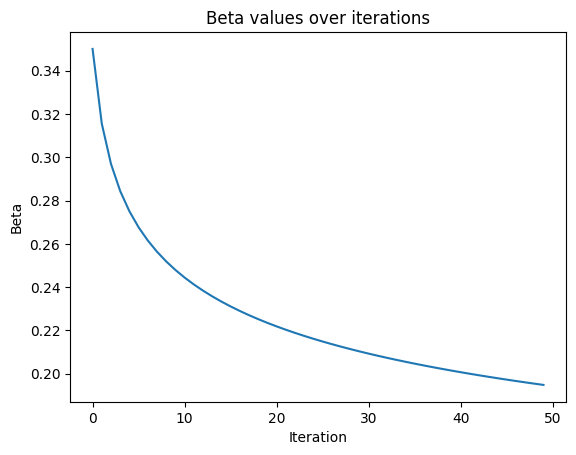

In [9]:
def calculate_beta_log(n, total_iterations=50, initial_beta=0.35, final_beta=0.001, smoothing_factor=0.1):
    # a scaling factor based on the initial and final beta values
    scale_factor = (np.log(initial_beta) - np.log(final_beta)) / np.log(total_iterations) * smoothing_factor
    
    # beta value for the current iteration
    beta = np.exp(np.log(initial_beta) - scale_factor * np.log(n))
    
    if beta < final_beta:
        beta = final_beta
    return beta

betas = []
for n in range(1, 51):
    beta = calculate_beta_log(n)
    betas.append(beta)
    # print(f"Iteration {n}: beta = {beta:.6f}")

from matplotlib import pyplot as plt

plt.plot(betas)
plt.xlabel('Iteration')
plt.ylabel('Beta')
plt.title('Beta values over iterations')
plt.show()

In [69]:
# OLD STUFF

from sklearn.model_selection import train_test_split

sslc_pose = pd.read_csv('sslc_pose_2.csv', encoding='utf-8')
train_df, test_df = train_test_split(sslc_pose, test_size=0.2, random_state=42)

import importlib
import utils
utils = importlib.reload(utils)

train_dataset = utils.PoseDataset(
    df=train_df, root_dir='./SSL_video_eaf/SSLC_poses/',
    sequence_length=sequence_length, normalize_by_mean_pose=True
)
test_dataset = utils.PoseDataset(
    df=test_df, root_dir='./SSL_video_eaf/SSLC_poses/',
    sequence_length=sequence_length, normalize_by_mean_pose=True
)

True
True


In [10]:
import importlib
import utils
utils = importlib.reload(utils)
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
# from sign_vq.dataset import ZipPoseDataset, PackedDataset
# TODO: add some kind of collate function to the DataLoader


def load_data(path_to_data, output_dim=112, normalize_by_mean_pose=True, num_workers=0, batch_size=256):
    """ load up to torch.utils.data.DataLoader """
    
    sslc_pose = pd.read_csv('sslc_pose_2.csv', encoding='utf-8')
    
    if path_to_data.endswith(".zip"):
        dataset = utils.ZipPoseDataset(
            path_to_data, in_memory=True,
            dtype=torch.float32,
            max_length=output_dim,
            df=sslc_pose
        )
        
        training_dataset = dataset.slice(50, None)  # TODO: change to 10%
        test_dataset = dataset.slice(0, 50)   # TODO: change to 10%
        shuffle = True  # Shuffle is only slow without in_memory since the zip file is read sequentially
        num_workers = 0  # Reading from multiple workers errors out since the zip file is read sequentially

        # training_iter_dataset = utils.PackedDataset(training_dataset, max_length=sequence_length, shuffle=shuffle)
        
        train_loader = DataLoader(
            training_dataset, batch_size=batch_size,
            num_workers=num_workers
        )
        test_loader = DataLoader(
            test_dataset, batch_size=batch_size,
            shuffle=False, num_workers=num_workers
        )
    else:
        train_df, test_df = train_test_split(sslc_pose, test_size=0.2, random_state=42)
        
        training_dataset = utils.PoseDataset(
            df=train_df, root_dir='./SSL_video_eaf/SSLC_poses/',
            sequence_length=sequence_length, normalize_by_mean_pose=normalize_by_mean_pose
        )
        test_dataset = utils.PoseDataset(
            df=test_df, root_dir='./SSL_video_eaf/SSLC_poses/',
            sequence_length=sequence_length, normalize_by_mean_pose=normalize_by_mean_pose
        )

        kwargs = {'num_workers': num_workers, 'pin_memory': True} 

        train_loader = DataLoader(dataset=training_dataset, batch_size=batch_size, shuffle=False, **kwargs)
        test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False,  **kwargs)

    return training_dataset, test_dataset, train_loader, test_loader


training_dataset, test_dataset, train_loader, test_loader = load_data(
    './SSL_video_eaf/SSLC_poses_norm.zip', output_dim=output_dim,
    normalize_by_mean_pose=False, num_workers=1,
    batch_size=256
)

ZipPoseDataset @ ./SSL_video_eaf/SSLC_poses_norm.zip with max_length=112, in_memory=True
Total files 512


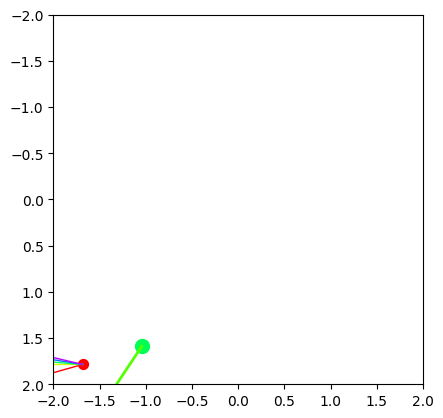

In [50]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots()
utils.draw_from_tensor(test_dataset[0][:,0], ax)
ax.set_xlim(-2, 2)
ax.set_ylim(2, -2)
ax.set_aspect('equal')
plt.show()

It looks much better size wise after trimming the empty frames at the start and the end of the video

Compare normalized pose to unnormalized on a random frame

In [17]:
training_dataset[10][:,0].size()

torch.Size([112])

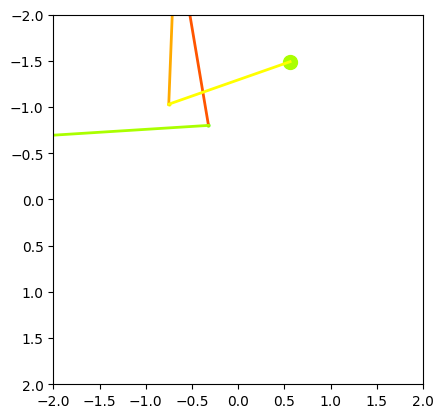

In [18]:
fig, ax = plt.subplots()
utils.draw_from_tensor(training_dataset.__getitem__(1)[:,0], ax)
ax.set_xlim(-2, 2)
ax.set_ylim(2, -2)
ax.set_aspect('equal')
plt.show()

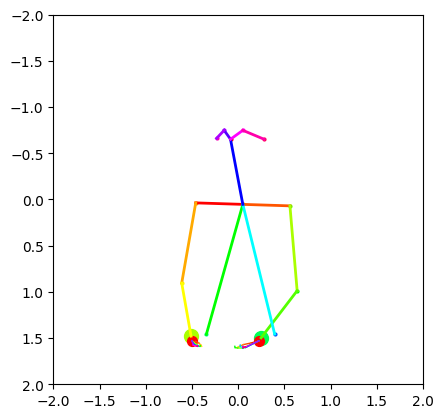

In [19]:
fig, ax = plt.subplots()
utils.draw_from_tensor(utils.unnormalize_mean_std(training_dataset[3][:,0]), ax)
ax.set_xlim(-2, 2)
ax.set_ylim(2, -2)
ax.set_aspect('equal')
plt.show()

In [22]:
# OLD STUFF
from torch.utils.data import DataLoader

kwargs = {'num_workers': 1, 'pin_memory': True} 

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False,  **kwargs)

In [12]:
#train_loader_sign = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
#data_iter = iter(train_loader)
#print(data_iter)
#type(train_loader)

In [14]:
#!y| pip uninstall numpy
#!pip install numpy==1.23.2

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Would remove:
    /conda/envs/vqvae-anya/bin/f2py
    /conda/envs/vqvae-anya/lib/python3.9/site-packages/numpy-1.26.4.dist-info/*
    /conda/envs/vqvae-anya/lib/python3.9/site-packages/numpy.libs/libgfortran-040039e1.so.5.0.0
    /conda/envs/vqvae-anya/lib/python3.9/site-packages/numpy.libs/libopenblas64_p-r0-0cf96a72.3.23.dev.so
    /conda/envs/vqvae-anya/lib/python3.9/site-packages/numpy.libs/libquadmath-96973f99.so.0.0.0
    /conda/envs/vqvae-anya/lib/python3.9/site-packages/numpy/*
Proceed (Y/n)?   Successfully uninstalled numpy-1.26.4
yes: standard output: Broken pipe
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 103.8 MB/s eta 0:00:00a 0:00:01


In [1]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 80.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 143.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 151.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 156.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.1/281.1 kB 152.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 133.8 MB/s eta 0:00:00


In [20]:
!wandb login --relogin d1253183cef81ffd1fb36585541869e753355bd6

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [11]:
import wandb
import torch.optim as optim
from torch.optim import AdamW, Adam

# Initialize W&B
wandb.init(project="vqvae_on_ssl", name="restart-fromzip")

mse_loss = nn.MSELoss()
optimizer = AdamW(model.parameters(), lr=lr)

print("Start training VQ-VAE...")
model.train()

use_amp = False

# Constructs a ``scaler`` once, at the beginning of the convergence run, using default arguments.
# If your network fails to converge with default ``GradScaler`` arguments, please file an issue.
# The same ``GradScaler`` instance should be used for the entire convergence run.
# If you perform multiple convergence runs in the same script, each run should use
# a dedicated fresh ``GradScaler`` instance. ``GradScaler`` instances are lightweight.
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

for epoch in range(epochs):
    
    commitment_beta = calculate_beta_log(epoch+1, total_iterations=epochs+1, initial_beta=0.35, final_beta=0.001, smoothing_factor=0.1)
    
    for batch_idx, x in enumerate(train_loader):
        
        # optimizer.zero_grad()
        
        if x is None:
            ("x is None")
            continue
            
            # https://pytorch.org/docs/stable/amp.html#autocast-op-reference
        """
        with torch.autocast(device_type=device, dtype=torch.float16, enabled=use_amp):
            x = x.to(device, torch.float16)
            print("x.device: ", x.device)

            x_hat, commitment_loss, codebook_loss, perplexity = model(x, epoch)
            print("x_hat.device: ", x_hat.device)
            assert x_hat.dtype is torch.float16

            print("commitment_loss.device, codebook_loss.device: ", commitment_loss.device, codebook_loss.device)

            recon_loss = mse_loss(x_hat, x)
            print("recon_loss: ", recon_loss.device)
            # loss is float32 because ``mse_loss`` layers ``autocast`` to float32
            assert recon_loss.dtype is torch.float32
        """
        x = x.to(device)
        print("x.device: ", x.device)
        x_hat, commitment_loss, codebook_loss, perplexity = model(x, epoch)
        print("x_hat.device: ", x_hat.device)
        recon_loss = mse_loss(x_hat, x)
        print("recon_loss: ", recon_loss.device)

        # for the first 5 epochs loss == recon_loss, aka. no quantisation, warm up 
        loss = recon_loss + commitment_loss * commitment_beta + codebook_loss
        print(loss)

        # Print gradient norms before scaling
        for name, param in model.named_parameters():
            if param.grad is not None:
                print(f"Before scaling - {name}: grad norm {param.grad.norm(2)}")

        # Exits ``autocast`` before backward().
        # Backward passes under ``autocast`` are not recommended.
        # Backward ops run in the same ``dtype`` ``autocast`` chose for corresponding forward ops.
        # Scales loss. Calls ``backward()`` on scaled loss to create scaled gradients.
        # scaler.scale(loss).backward()
        loss.backward()

        # Print gradient norms
        for name, param in model.named_parameters():
            if param.grad is not None:
                print(f"After scaling - {name}: grad norm {param.grad.norm(2)}")
                
        # scaler.unscale_(optimizer)
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)
        
        # Print gradient norms 
        for name, param in model.named_parameters():
            if param.grad is not None:
                print(f"After gradient clipping - {name}: grad norm {param.grad.norm(2)}")
        
        # ``scaler.step()`` first unscales the gradients of the optimizer's assigned parameters.
        # If these gradients do not contain ``inf``s or ``NaN``s, optimizer.step() is then called,
        # otherwise, optimizer.step() is skipped.
        # scaler.step(optimizer)
        optimizer.step()
        optimizer.zero_grad()

        # Updates the scale for next iteration.
        # scaler.update()
     
        wandb.log({
            'epoch': epoch + 1,
            'batch_idx': batch_idx + 1,
            'recon_loss': recon_loss.item(),
            'commitment_loss': commitment_loss.item(),
            'codebook_loss': codebook_loss.item(),
            'total_loss': loss.item(),
            'perplexity': perplexity.item()
        })
            
        if batch_idx % print_step == 0: 
            print("epoch:", epoch + 1, "(", batch_idx + 1, ") recon_loss:", recon_loss.item(), " perplexity: ", perplexity.item(), 
                " commit_loss: ", commitment_loss.item(), "\n\t codebook loss: ", codebook_loss.item(), " total_loss: ", loss.item(), "\n")
        
    
    codebook.random_restart()
    codebook.reset_usage()
    
print("Finish!!")
wandb.finish()

wandb: Currently logged in as: anna-klezovich24 (annaklezovich1997). Use `wandb login --relogin` to force relogin


Start training VQ-VAE...
x.device:  cuda:0
Encoder output:  torch.Size([256, 16, 26])
x shape that is passed into Decoder:
 torch.Size([256, 16, 26])
x_hat.device:  cuda:0
recon_loss:  cuda:0
tensor(16.5492, device='cuda:0', grad_fn=<AddBackward0>)
After scaling - encoder.strided_conv_1.weight: grad norm 1.8473109006881714
After scaling - encoder.strided_conv_1.bias: grad norm 0.01726767048239708
After scaling - encoder.strided_conv_2.weight: grad norm 3.937825918197632
After scaling - encoder.strided_conv_2.bias: grad norm 0.02983541414141655
After scaling - encoder.residual_conv_1.weight: grad norm 1.9096412658691406
After scaling - encoder.residual_conv_1.bias: grad norm 0.03572901338338852
After scaling - encoder.residual_conv_2.weight: grad norm 2.269587755203247
After scaling - encoder.residual_conv_2.bias: grad norm 0.04091662913560867
After scaling - encoder.proj.weight: grad norm 4.472853660583496
After scaling - encoder.proj.bias: grad norm 0.0716012492775917
After scaling - 

batch_idx,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
codebook_loss,█▃▂▁▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
commitment_loss,█▃▂▁▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
perplexity,▁▂▃▃▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████████████
recon_loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
total_loss,█▄▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_idx,2
codebook_loss,0.54487
commitment_loss,0.13622
epoch,200


In [12]:
## vq_vae_warmup_beta.pth
# the data for this model was trimmed from 110 beginning frames and 40 end frames
# the commitment beta warm up was introduced (in range from 0.3 to 0.1), the previous one was 0.25 and it was too big I think

## vq_vae_restart-beta-quantwarmup.pth
# the for this model was trimmed from 110 beginning frames and 40 end frames
# commitment beta is going from 0.35(actually less-0.26) to 0.001 with smoothing 0.1
# no quantisation on the first five epochs
# codebook restart for dead codes each epoch
# Xavier initialization for embeddings
torch.save(model.state_dict(), 'vq_vae_restart-nowarmup-from-zip-noamp-200epochs.pth')

In [13]:
checkpoint = {"model": model.state_dict(),
              "optimizer": optimizer.state_dict(),
              "scaler": scaler.state_dict()}
torch.save(checkpoint, "vq_vae_restart-nowarmup-from-zip-noamp-200epochs.pth")

In [ ]:
dev = torch.cuda.current_device()
checkpoint = torch.load("vq_vae_restart-nowarmup-from-zip-float16.pth",
                        map_location = lambda storage, loc: storage.cuda(dev))
model.load_state_dict(checkpoint["model"])
optimizer.load_state_dict(checkpoint["optimizer"])
scaler.load_state_dict(checkpoint["scaler"])

In [23]:
model = Model(Encoder=encoder, Codebook=codebook, Decoder=decoder)
model.load_state_dict(torch.load('vq_vae_restart-nowarmup-from-zip-bfloat16.pth', map_location=torch.device('cpu')))
model.eval()

Model(
  (encoder): Encoder(
    (strided_conv_1): Conv1d(112, 512, kernel_size=(3,), stride=(1,), padding=(1,))
    (strided_conv_2): Conv1d(512, 512, kernel_size=(3,), stride=(1,))
    (residual_conv_1): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(1,))
    (residual_conv_2): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(1,))
    (proj): Conv1d(512, 16, kernel_size=(3,), stride=(1,))
  )
  (codebook): VQEmbeddingEMA()
  (decoder): Decoder(
    (in_proj): Conv1d(16, 512, kernel_size=(3,), stride=(1,))
    (residual_conv_1): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(1,))
    (residual_conv_2): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(1,))
    (strided_t_conv_1): ConvTranspose1d(512, 512, kernel_size=(3,), stride=(1,))
    (strided_t_conv_2): ConvTranspose1d(512, 112, kernel_size=(3,), stride=(1,), dilation=(2,))
  )
)

In [13]:
import wandb

def test(data_loader, model):
    """evaluation model"""
    wandb.init(project="vqvae_on_ssl", job_type="test", name="zipped-test")
    # model.eval()
    N = len(data_loader)
    epoch=10
    with torch.no_grad():
        recon_loss, loss_vq = 0., 0.
        for batch_idx, x in enumerate(data_loader):
            if x is None:
                ("x is None")
                continue
            x = x.to(device)
            x_hat, commitment_loss, codebook_loss, _ = model(x, epoch=10)
            mse = mse_loss(x_hat, x)
            recon_loss += mse
            loss = recon_loss + commitment_loss * commitment_beta + codebook_loss
            loss_vq += loss
            wandb.log({
                'test_recon_loss': mse.item(),
                'test_total_loss': loss.item()
                })
        recon_loss /= N
        loss_vq /= N
        wandb.log({
            'average_test_recon_loss': recon_loss,
            'average_test_total_loss': loss_vq
        })
        print("epoch:", epoch + 1, "(", batch_idx + 1, ") average_test_recon_loss:", recon_loss, " average_test_total_loss: ", loss_vq, "\n")
    wandb.finish()
    return recon_loss, loss_vq

In [14]:
loss_recons, loss_total = test(test_loader, model)

Encoder output:  torch.Size([50, 16, 26])
x shape that is passed into Decoder:
 torch.Size([50, 16, 26])
epoch: 11 ( 1 ) average_test_recon_loss: tensor(0.6316, device='cuda:0')  average_test_total_loss:  tensor(2.0421, device='cuda:0') 



average_test_recon_loss,▁
average_test_total_loss,▁
test_recon_loss,▁
test_total_loss,▁
average_test_recon_loss,0.63164
average_test_total_loss,2.04212
test_recon_loss,0.63164
test_total_loss,2.04212


In [15]:
# average losses for test batches - the test data is not normalized
print(loss_recons, loss_total)

tensor(0.6316, device='cuda:0') tensor(2.0421, device='cuda:0')


**SSLC corpus data**


* first run, codebook collapse - `tensor(0.0091, device='cuda:0') tensor(0.0132, device='cuda:0')`
* second run, warm up beta, codebook collapse, but video reconstruction looks a little better - `tensor(0.0383, device='cuda:0') tensor(0.1051, device='cuda:0')`
* `vq_vae_restart-beta-quantwarmup.pth`. the video for this model was trimmed from 110 beginning frames and 40 end frames, commitment beta is going from 0.35(actually less-0.26) to 0.001 with smoothing 0.1, no quantisation on the first five epochs, codebook restart for dead codes each epoch, Xavier initialization for embeddings - `tensor(0.0472, device='cuda:0') tensor(0.0862, device='cuda:0')`
* `vq_vae_restart-warmup-normpose.pth`. the video for this model was trimmed from 110 beginning frames and 40 end frames, commitment beta is going from 0.35(actually less-0.26) to 0.001 with smoothing 0.1, no quantisation on the first five epochs, codebook restart for dead codes each epoch, Xavier initialization for embeddings. The data is normalized with `(data - mean)/std` with the help of mean pose. - test data is also normalized - `tensor(0.1960) tensor(0.3829)`, on non normalized data it's somehow better `tensor(0.1485) tensor(0.1896)`
* `vq_vae_restart-nowarmup-normpose.pth` - the video for this model was trimmed from 110 beginning frames and 40 end frames, commitment beta is going from 0.35(actually less-0.26) to 0.001 with smoothing 0.1, no warm up, codebook restart for dead codes each epoch, Xavier initialization for embeddings. The data is normalized with `(data - mean)/std` with the help of mean pose. Test data is also normalized - `tensor(0.3448) tensor(0.9293)`
* `vq_vae_restart-nowarmup-normpose-from-zip-float16.pth` - the video for this model was trimmed from 110 beginning frames and 40 end frames, commitment beta is going from 0.35(actually less-0.26) to 0.001 with smoothing 0.1, no warm up, codebook restart for dead codes each epoch, Xavier initialization for embeddings. Dataset is wrapped in zip. The data is normalized with `(data - mean)/std` with the help of mean pose. Test data is also normalized. Extremely fast, because I use zip archive and do everything in float16 instead of float32. The training run perplexity is **117.2675**!
* `'vq_vae_restart-nowarmup-from-zip-amp.pth` - the video for this model was trimmed from 110 beginning frames and 40 end frames, commitment beta is going from 0.35(actually less-0.26) to 0.001 with smoothing 0.1, no warm up, codebook restart for dead codes each epoch, Xavier initialization for embeddings. The data is not normalized. Dataset is wrapped in zip. The model is trained with the help of torch mixed precision amp with float16/half. The training perplexity is **157.15**. `average_test_recon_loss: tensor(1.2258, device='cuda:0')  average_test_total_loss:  tensor(2.9373, device='cuda:0')`.
* `vq_vae_restart-nowarmup-from-zip-noamp-200epochs.pth` - the video for this model was trimmed from 110 beginning frames and 40 end frames, commitment beta is going from 0.35(actually less-0.26) to 0.001 with smoothing 0.1, no warm up, codebook restart for dead codes each epoch, Xavier initialization for embeddings. The data is normalized with `(data - mean)/std` with the help of mean pose. Test data is also normalized. Dataset is wrapped in zip. No mixed precision amp with float16/half. Trained on 200 epochs. The training perplexity is **219.824**. - `tensor(0.6316, device='cuda:0') tensor(2.0421, device='cuda:0')`

In [22]:
test_dataset = utils.PoseDataset(
    df=test_df, root_dir='./SSL_video_eaf/SSLC_poses/',
    sequence_length=sequence_length, normalize_by_mean_pose=True
)
test_loader = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False,  **kwargs)
loss_recons, loss_total = test(test_loader, model)

average_test_recon_loss,▁
average_test_total_loss,▁
test_recon_loss,▁
test_total_loss,▁
average_test_recon_loss,0.38914
average_test_total_loss,0.66984
test_recon_loss,0.38914
test_total_loss,0.66984


epoch: 11 ( 1 ) average_test_recon_loss: tensor(0.1960)  average_test_total_loss:  tensor(0.3829) 



average_test_recon_loss,▁
average_test_total_loss,▁
test_recon_loss,▁
test_total_loss,▁
average_test_recon_loss,0.19597
average_test_total_loss,0.3829
test_recon_loss,0.19597
test_total_loss,0.3829


In [24]:
# average losses for test batches - the test data IS normalized
print(loss_recons, loss_total)

tensor(0.1960) tensor(0.3829)


### Evaluation

In [16]:
import matplotlib.pyplot as plt
utils = importlib.reload(utils)

In [17]:
model.eval()

with torch.no_grad():

    for batch_idx, x in enumerate(tqdm(test_loader)):

        x = x.to(device)
        x_hat, commitment_loss, codebook_loss, perplexity = model(x, epoch=10)
 
        print("perplexity: ", perplexity.item(), "commit_loss: ", commitment_loss.item(), "  codebook loss: ", codebook_loss.item())
        break

  0%|          | 0/1 [00:00<?, ?it/s]

Encoder output:  torch.Size([50, 16, 26])
x shape that is passed into Decoder:
 torch.Size([50, 16, 26])
perplexity:  196.14186096191406 commit_loss:  0.3298075497150421   codebook loss:  1.3192301988601685


**SSLC corpus data**


- perplexity:  30.4245491
- commit_loss:  0.0160329286
- codebook loss:  0.0641317144

============= `vq_vae_restart-beta-quantwarmup.pth` Xavier, restart codebook, frozen codebook on first 5 steps, beta decay ===========

- perplexity:  53.5902
- commit_loss:  0.016567938
- codebook loss:  0.06627175

============= `vq_vae_restart-warmup-normpose.pth` ===========

- perplexity:  66.249382
- commit_loss:  0.055224929
- codebook loss:  0.220899716

============= `vq_vae_restart-nowarmup-normpose.pth` ===========

- perplexity: 72.8709869
- commit_loss: 0.155359
- codebook loss: 0.621436357498

============= `vq_vae_restart-nowarmup-normpose-from-zip-float16.pth` ===========

- perplexity:  90.21179199
- commit_loss:  1.4155819416
- codebook loss:  5.6623277664

============= `vq_vae_restart-nowarmup-from-zip-amp.pth` ==============

- perplexity:  138.46998596
- commit_loss:  0.4079417586
- codebook loss:  1.631767

============= `vq_vae_restart-nowarmup-from-zip-noamp-200epochs.pth` ================

- perplexity:  196.14186096
- commit_loss:  0.3298075497
- codebook loss:  1.31923

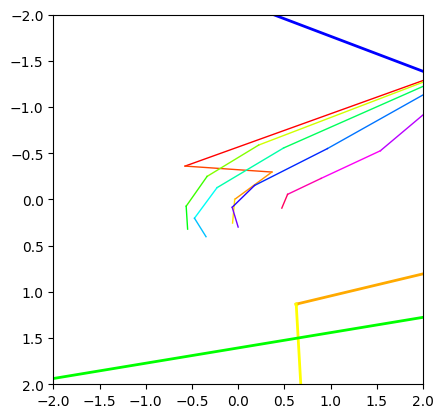

In [19]:
tensor2 = x[7].cpu()
fig, ax = plt.subplots()
utils.draw_from_tensor(tensor2[:,0], ax)
ax.set_xlim(-2, 2)
ax.set_ylim(2, -2)
ax.set_aspect('equal')
plt.show()

frame  0
frame  0
frame  0
frame  0
frame  1
frame  2
frame  3
frame  4
frame  5
frame  6
frame  7
frame  8
frame  9
frame  10
frame  11
frame  12
frame  13
frame  14
frame  15
frame  16
frame  17
frame  18
frame  19
frame  20
frame  21
frame  22
frame  23
frame  24
frame  25
frame  26
frame  27
frame  28


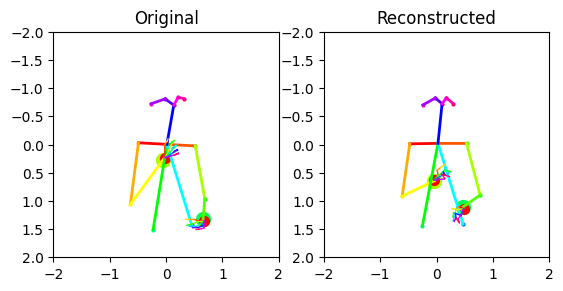

In [23]:
# Plotting video for comparison

from matplotlib.animation import FuncAnimation

#for i in range(5):
sample_id = 20 #i
fig, (ax1, ax2) = plt.subplots(1, 2)  # Create subplots with 1 row and 2 columns

def unnormalize_all_frames(tensor):
    unnorm_frames = []
    for i in range(tensor.size(1)):
        column = tensor[:, i]
        unnorm_frame = utils.unnormalize_mean_std(column)
        unnorm_frames.append(unnorm_frame)
    # Stack the normalized columns back into a tensor
    unnormalized_tensor = torch.stack(unnorm_frames, dim=1)
    return unnormalized_tensor

def draw_sample_video(n):
    ax1.clear()
    ax2.clear()
    print('frame ', n)
    artists = []
    
    tensor = x.to(dtype=torch.float32)[sample_id].cpu()
    tensor = unnormalize_all_frames(tensor)
    
    # Plot the first data
    utils.draw_from_tensor(tensor[:, n], ax1)
    ax1.set_xlim(-2, 2)
    ax1.set_ylim(2, -2)
    ax1.set_aspect('equal')
    ax1.set_title('Original')

    tensor2 = x_hat.to(dtype=torch.float32)[sample_id].cpu()
    tensor2 = unnormalize_all_frames(tensor2)
    
    # Plot the second data
    utils.draw_from_tensor(tensor2[:, n], ax2)
    ax2.set_xlim(-2, 2)
    ax2.set_ylim(2, -2)
    ax2.set_aspect('equal')
    ax2.set_title('Reconstructed')
    
    #plt.show()
    return artists

ani = FuncAnimation(fig, draw_sample_video, frames=29, interval=30, blit=True)

from IPython.display import HTML
HTML(ani.to_html5_video())

In [98]:
# It is much faster to draw single videos so keeping this
def draw_gen_sample_image(n):
    ax.clear()
    artists = []
    tensor2 = x_hat[sample_id].cpu()
    utils.draw_from_tensor(tensor2[:,n], ax)
    ax.set_xlim(-2, 2)
    ax.set_ylim(2, -2)
    ax.set_aspect('equal')
    #plt.show()
    return artists

ani = FuncAnimation(fig, draw_gen_sample_image, frames=29, interval=30, blit=True)
plt.show()

from IPython.display import HTML
HTML(ani.to_html5_video())


KeyboardInterrupt



In [34]:
def draw_gt_sample_image(n):
    ax.clear()
    artists = []
    tensor2 = x[sample_id].cpu()
    utils.draw_from_tensor(tensor2[:,n], ax)
    ax.set_xlim(-2, 2)
    ax.set_ylim(2, -2)
    ax.set_aspect('equal')
    #plt.show()
    return artists

ani = FuncAnimation(fig, draw_gen_sample_image, frames=29, interval=30, blit=True)
plt.show()

from IPython.display import HTML
HTML(ani.to_html5_video())

NameError: name 'draw_gen_sample_image' is not defined

### Below is unchanged but 

In [31]:
def draw_sample_image(x, postfix):
  
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Visualization of {}".format(postfix))
    plt.imshow(np.transpose(make_grid(x.detach().cpu(), padding=2, normalize=True), (1, 2, 0)))

torch.Size([112])
torch.Size([56, 2])


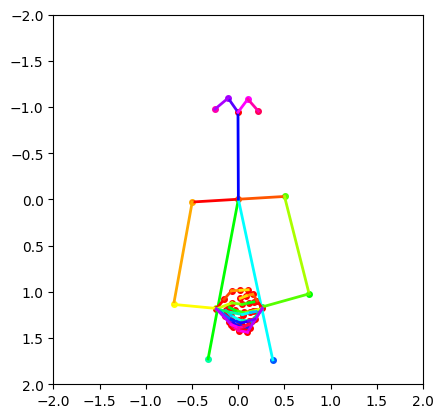

torch.Size([112])
torch.Size([56, 2])


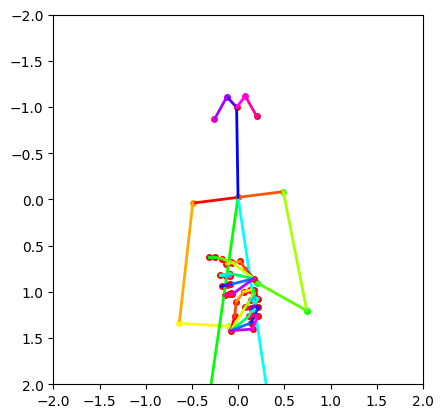

torch.Size([112])
torch.Size([56, 2])


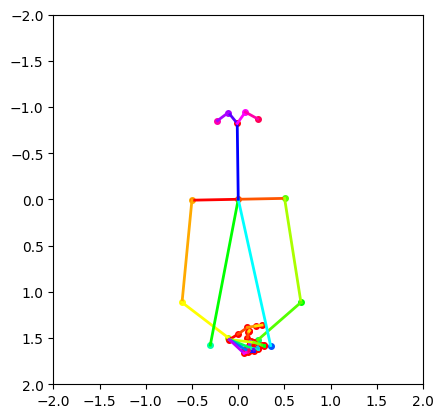

torch.Size([112])
torch.Size([56, 2])


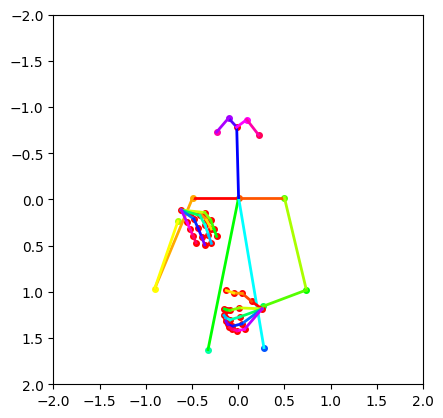

torch.Size([112])
torch.Size([56, 2])


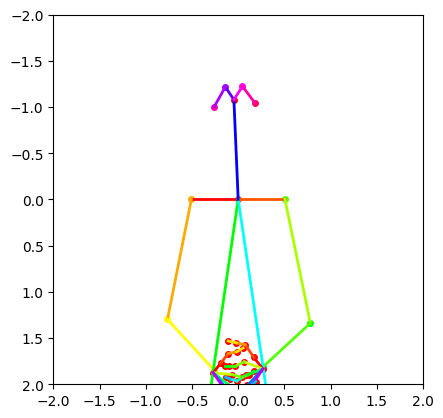

In [39]:
for i in range(40):
    draw_sample_image(x[i], "Ground-truth images")

torch.Size([112])
torch.Size([56, 2])


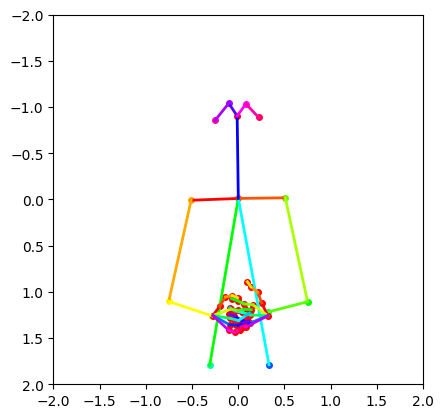

In [35]:
draw_sample_image(x_hat, "Reconstructed images")

### Todo: Fix so we can sample from latent

In [31]:
def draw_random_sample_image(codebook, decoder, indices_shape):
    
    random_indices = torch.floor(torch.rand(indices_shape) * n_embeddings).long().to(DEVICE)
    codes = codebook.retrieve_random_codebook(random_indices)
    x_hat = decoder(codes.to(DEVICE))
    
    tensor2 = x_hat[0].cpu()
    fig, ax = plt.subplots()
    utils.draw_from_tensor(tensor2[:,0], ax)
    ax.set_xlim(-2, 2)
    ax.set_ylim(2, -2)
    ax.set_aspect('equal')
    plt.show()

In [37]:
draw_random_sample_image(codebook, decoder, indices_shape=(batch_size//2, 8))

IndexError: Dimension out of range (expected to be in range of [-3, 2], but got 3)